# Imports

In [1]:
import os

from pandas.core.interchange.dataframe_protocol import DataFrame

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

%load_ext autoreload
%autoreload 2

In [ ]:
pip install "mlforecast[core]"

In [ ]:
pip install catboost

In [ ]:
pip install neuralforecast

In [2]:
import numpy as np
from coreforecast.rolling import rolling_mean
from mlforecast.lag_transforms import RollingMean
from sklearn.metrics import mean_squared_error
import pandas as pd
from utilsforecast.plotting import plot_series
import numpy as np
import pandas as pd
import seaborn as sns
from coreforecast.lag_transforms import ExpandingMean
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
import re


from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from mlforecast import MLForecast
from mlforecast.core import TimeSeries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Data Loading & Preprocessing

In [3]:
# Set the paths
data_path = "/Users/adi.k/Desktop/Reichman/Advanced ML/Final project/Data/"

# Load CSVs
train = pd.read_csv(data_path + "train.csv", parse_dates=["date"])
calendar = pd.read_csv(data_path + "calendar_events.csv", parse_dates=["date"])
submission = pd.read_csv(data_path + "forecast_submission.csv")

In [4]:
def preprocess(df, calendar, first_timestep = 0):
    df = df.dropna()

    # Rename columns
    df = df.rename(columns={'store_name': 'unique_id', 'date': 'ds', 'revenue': 'y'})

    # Interpolate the zero-values (xmas)
    if 'y' in df.columns:
        df.loc[df['y'] == 0, 'y'] = np.nan
        df['y'] = df.groupby('unique_id')['y'].transform(lambda s: s.interpolate(method='linear'))

    # Timestep columns
    df = df.sort_values('ds')
    date_to_timestep = {date: i + first_timestep for i, date in enumerate(sorted(df['ds'].unique()))}
    df['timestep'] = df['ds'].map(date_to_timestep)

    # Merge with calendar events
    df = df.merge(calendar.rename(columns={'date': 'ds'}), on='ds', how='left')
    df['event'] = df['event'].fillna('None')

    # Get all known event types (including 'None')
    all_events = calendar['event'].dropna().unique().tolist()
    all_events.append('None')

    # Convert to categorical with fixed categories
    df['event'] = pd.Categorical(df['event'], categories=all_events)

    # One-hot encode
    df = pd.get_dummies(df, columns=['event'], prefix='event')

    # Sanitize column names
    df.columns = [clean_column(col) for col in df.columns]

    return df


def clean_column(name):
    return re.sub(r'\W+', '_', name)


def plot_df(df, count = 4):
    store_counts = df['unique_id'].value_counts()
    top_stores = store_counts[store_counts.index != 'All Stores'].head(count).index.tolist()

    # Plot revenue over time for top 4 stores
    fig, axs = plt.subplots(len(top_stores), 1, figsize=(12, 10), sharex=True)

    for i, store in enumerate(top_stores):
        sns.lineplot(data=df[df['unique_id'] == store], x='ds', y='y', ax=axs[i])
        axs[i].set_title(f'Store: {store}')
        axs[i].set_ylabel('Revenue')

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


def plot_forecasts(df_actual, df_forecast, models, store_ids=None, history_days=60):
    """
    Plots actual vs forecasted revenue for selected stores.

    Parameters:
    - df_actual: DataFrame with actuals (`ds`, `y`, `unique_id`)
    - df_forecast: DataFrame with forecast (`ds`, `y_pred`, `unique_id`)
    - store_ids: list of store names to plot
    - history_days: number of days of actual data to show
    """
    if store_ids is None:
        store_ids = df_forecast['unique_id'].unique()[:3]  # default to first 3 stores

    fig, axs = plt.subplots(len(store_ids), 1, figsize=(12, 4 * len(store_ids)), sharex=True)

    if len(store_ids) == 1:
        axs = [axs]

    for i, store_id in enumerate(store_ids):
        ax = axs[i]
        actual = df_actual[df_actual['unique_id'] == store_id].sort_values('ds')
        forecast = df_forecast[df_forecast['unique_id'] == store_id].sort_values('ds')

        ax.plot(actual['ds'].iloc[-history_days:], actual['y'].iloc[-history_days:], label='Actual', linewidth=2)

        for model in models:
            ax.plot(forecast['ds'], forecast[model], label=model, linestyle='--', marker='o')

        ax.set_title(f'Forecast vs Actual for {store_id}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def split_train_test(df, h):
    last_dates = df.groupby('unique_id')['ds'].max().reset_index()
    cutoff_dates = last_dates.copy()
    cutoff_dates['cutoff'] = cutoff_dates['ds'] - pd.Timedelta(days=h)

    df = df.merge(cutoff_dates[['unique_id', 'cutoff']], on='unique_id')
    train_df = df[df['ds'] <= df['cutoff']].drop(columns='cutoff')
    test_df = df[df['ds'] > df['cutoff']].drop(columns='cutoff')
    return train_df, test_df


def calc_rmse(df_actual, df_forecast):
    merged = df_actual.merge(df_forecast, on=['unique_id', 'ds'], how='left')
    rmse = {}
    for model in df_forecast.drop(columns=['unique_id', 'ds']).columns:
        rmse[model] = np.sqrt(mean_squared_error(merged['y'], merged[model]))
        print(f"{model}: {rmse[model]:.2f}")

    return rmse

In [ ]:
h = 28  # number of days to predict
df = preprocess(train, calendar)

In [5]:
h = 28  # number of days to predict

df = preprocess(train, calendar)
train_df, test_df = split_train_test(df, h=h)

# ML Forecast

### Original training ( Including "All Stores")

In [ ]:
# Define exogenous features (event columns)
exog_vars = [col for col in df.columns if col.startswith('event_')]
test_vars = ['unique_id', 'ds'] + exog_vars
train_vars = ['y'] + test_vars

# Create TimeSeries object

# Define ML models
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0),
    HistGradientBoostingRegressor()
]

# Initialize MLForecast
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14,28],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)

# Fit the model
mlf.fit(train_df[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

In [ ]:
# Predict using the full feature set
mlf_forecast = mlf.predict(h=h, X_df=test_df[test_vars])

In [ ]:
plot_forecasts(df, mlf_forecast, mlf.models)  # customize stores

In [ ]:
mlf_rmse = calc_rmse(test_df, mlf_forecast)

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def evaluate_store_model_rmse(test_df, mlf_forecast):
    # Merge forecast with actuals
    merged = test_df[['unique_id', 'ds', 'y', 'store_id']].merge(
        mlf_forecast,
        on=['unique_id', 'ds'],
        how='left'
    )

    merged = merged.dropna(subset=['y'])

    model_cols = [col for col in mlf_forecast.columns if col not in ['unique_id', 'ds']]

    # === Overall RMSE ===
    print("📊 Overall RMSE:")
    for model in model_cols:
        rmse_all = np.sqrt(mean_squared_error(merged['y'], merged[model]))
        print(f"• {model}: {rmse_all:.2f}")

    # === RMSE without store_id == 0 ===
    print("\n📉 Overall RMSE (excluding store_id == 0):")
    merged_no0 = merged[merged['store_id'] != 0]
    for model in model_cols:
        if not merged_no0.empty:
            rmse_excl_0 = np.sqrt(mean_squared_error(merged_no0['y'], merged_no0[model]))
            print(f"• {model} (no store 0): {rmse_excl_0:.2f}")

    # === Per-store RMSE + Rank ===
    print("\n🏬 Per-store RMSEs with Ranks:")
    store_rmse = []

    for store_id in sorted(merged['store_id'].unique()):
        store_df = merged[merged['store_id'] == store_id]
        store_metrics = {'store_id': store_id}

        for model in model_cols:
            rmse = np.sqrt(mean_squared_error(store_df['y'], store_df[model]))
            store_metrics[model] = rmse

        store_rmse.append(store_metrics)

    # Convert to DataFrame
    store_rmse_df = pd.DataFrame(store_rmse)

    # Melt to long format
    rmse_long = store_rmse_df.melt(id_vars='store_id', var_name='model', value_name='rmse')

    # Add rank: lower RMSE = better rank (1 = best)
    rmse_long['rank'] = rmse_long.groupby('store_id')['rmse'].rank(method='min')

    # Pivot to view nicely
    rmse_pivot = rmse_long.pivot(index='store_id', columns='model', values='rmse').round(2)
    rank_pivot = rmse_long.pivot(index='store_id', columns='model', values='rank').astype(int)

    print("\n📋 RMSE Table:")
    print(rmse_pivot)

    print("\n🥇 Model Rank Table (1 = best per store):")
    print(rank_pivot)

    return rmse_long  # in long format, useful for plotting or CSV

In [ ]:
rmse_long_df = evaluate_store_model_rmse(test_df, mlf_forecast)

####  Training without 'ALL Stores'

In [60]:
# define train without sum all stores

train_store_0 = train_df[train_df['store_id'] == 0].copy()
train_others = train_df[train_df['store_id'] != 0].copy()
train_others = train_others.sort_values(by=['store_id', 'ds'])

test_store_0 = test_df[test_df['store_id'] == 0].copy()
test_others = test_df[test_df['store_id'] != 0].copy()
test_others = test_others.sort_values(by=['store_id', 'ds'])

In [7]:
# Define exogenous features (event columns)
exog_vars = [col for col in df.columns if col.startswith('event_')]
test_vars = ['unique_id', 'ds'] + exog_vars
train_vars = ['y'] + test_vars

# Create TimeSeries object

# Define ML models
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0),
    HistGradientBoostingRegressor()
]

# Initialize MLForecast
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14,28],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)


# Fit the model
mlf.fit(train_others[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 13700, number of used features: 37
[LightGBM] [Info] Start training from score 22812.124716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 16500, number of used features: 38
[LightGBM] [Info] Start training from score 23738.150569


MLForecast(models=[LGBMRegressor, XGBRegressor, CatBoostRegressor, HistGradientBoostingRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14', 'lag28'], date_features=['dayofweek', 'month', 'is_month_end'], num_threads=4)

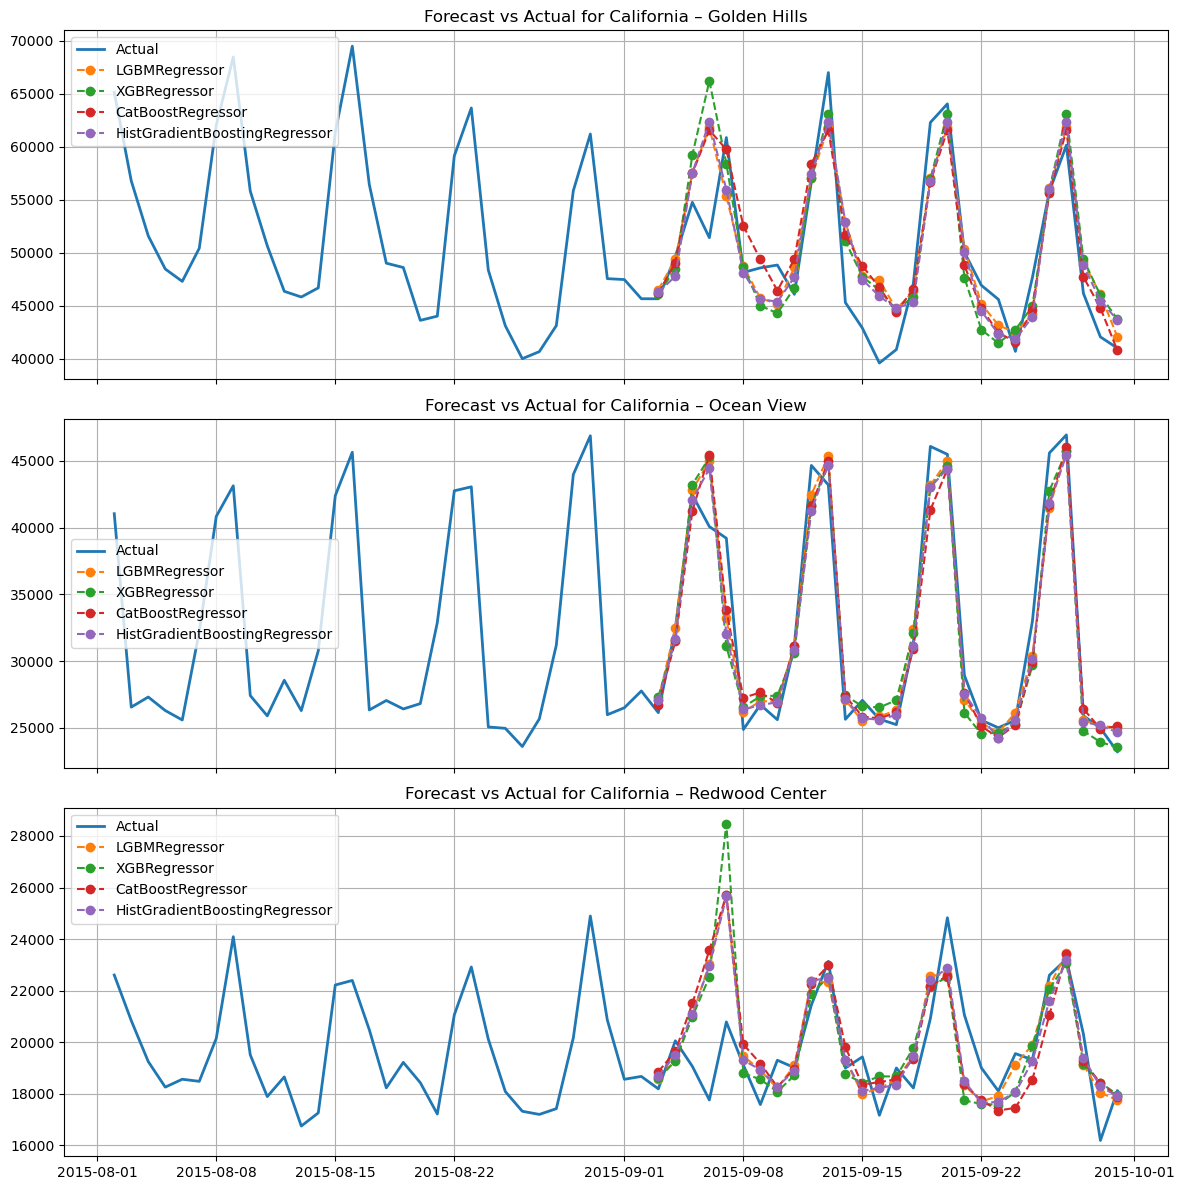

In [8]:
# Predict using the full feature set
mlf_forecast = mlf.predict(h=h, X_df=test_df[test_vars])
plot_forecasts(df, mlf_forecast, mlf.models)

In [16]:
# RMSE 
rmse_long_df = evaluate_store_model_rmse(test_others, mlf_forecast)

📊 Overall RMSE:
• LGBMRegressor: 2581.25
• XGBRegressor: 2669.32
• CatBoostRegressor: 2585.30
• HistGradientBoostingRegressor: 2534.80

📉 Overall RMSE (excluding store_id == 0):
• LGBMRegressor (no store 0): 2581.25
• XGBRegressor (no store 0): 2669.32
• CatBoostRegressor (no store 0): 2585.30
• HistGradientBoostingRegressor (no store 0): 2534.80

🏬 Per-store RMSEs with Ranks:

📋 RMSE Table:
model     CatBoostRegressor  HistGradientBoostingRegressor  LGBMRegressor   
store_id                                                                    
1                   2474.43                        2440.26        2398.40  \
2                   2256.06                        2194.37        2085.16   
3                   3755.46                        3928.67        3991.23   
4                   1929.34                        1771.29        1783.69   
5                   2010.15                        1999.92        2156.13   
6                   2539.36                        2393.03        

In [17]:
# Prediction for All stores samples by SUM UP precitions

def build_store0_forecast_from_individuals(mlf_forecast):
    model_cols = [col for col in mlf_forecast.columns if col not in ['unique_id', 'ds']]

    # Sum predictions per date across all stores
    store0_forecast = (
        mlf_forecast
        .groupby('ds')[model_cols]
        .sum()
        .reset_index()
    )

    # Assign "store 0" identity
    store0_forecast['unique_id'] = 'All Stores'  # or "All Stores", depending on your naming convention

    # Rearrange columns
    store0_forecast = store0_forecast[['unique_id', 'ds'] + model_cols]

    return store0_forecast


store0_forecast = build_store0_forecast_from_individuals(mlf_forecast)

In [18]:
# RMSE FOR STORE0

rmse0 = evaluate_store_model_rmse(test_store_0, store0_forecast)

📊 Overall RMSE:
• LGBMRegressor: 13225.24
• XGBRegressor: 13879.99
• CatBoostRegressor: 14180.25
• HistGradientBoostingRegressor: 12864.66

📉 Overall RMSE (excluding store_id == 0):

🏬 Per-store RMSEs with Ranks:

📋 RMSE Table:
model     CatBoostRegressor  HistGradientBoostingRegressor  LGBMRegressor   
store_id                                                                    
0                  14180.25                       12864.66       13225.24  \

model     XGBRegressor  
store_id                
0             13879.99  

🥇 Model Rank Table (1 = best per store):
model     CatBoostRegressor  HistGradientBoostingRegressor  LGBMRegressor   
store_id                                                                    
0                         4                              1              2  \

model     XGBRegressor  
store_id                
0                    3  


In [19]:
n1 = test_others[test_others['store_id'] != 0].shape[0]
n2 = test_store_0[test_store_0['store_id'] == 0].shape[0]
n1,n2

(280, 28)

In [20]:
def combined_rmse(rmse1, n1, rmse2, n2):
    total_error = n1 * rmse1**2 + n2 * rmse2**2
    total_count = n1 + n2
    return np.sqrt(total_error / total_count)

rmse = combined_rmse(rmse1=3030, n1=280, rmse2=14534, n2=28)
print(f"📊 Overall RMSE = {rmse:.2f}")


📊 Overall RMSE = 5248.78


# Neural Forecast

### Original Training with 'All Stores'

In [12]:
from neuralforecast.models import NHITS  # or RNN, TCN, NBEATS, etc.
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.models import RNN
from neuralforecast.models import LSTM
from neuralforecast.models import TCN

In [ ]:
# Define the model
models = [
    NHITS(input_size=4*h, h=h, max_steps=1000, scaler_type='standard', val_check_steps=100)
#     NBEATS(input_size=4*h, h=h, max_steps=1000),
#     RNN(input_size=4*h, h=h, max_steps=1000),
#     LSTM(input_size=4*h, h=h, max_steps=1000),
#     TCN(input_size=4*h, h=h, max_steps=1000)
]

# Initialize forecast object
nf = NeuralForecast(models=models, freq='D')

In [ ]:
#Fit the model
nf.fit(train_df[train_vars])

In [43]:
def predict_recursive(nf: NeuralForecast, future: DataFrame, train_df: DataFrame, train_vars: list):
    future = future.copy()
    history = train_df.copy()
    h = nf.h

    # Ensure y exists in future
    future['y'] = np.nan

    # Useful vars for slicing and joining
    vars_ext = train_vars + ['timestep']
    start = int(future['timestep'].min())
    end = int(future['timestep'].max())

    preds = []
    model_names = nf._get_model_names()

    for i in range(start, end, h):
        # 1. Predict the next h steps
        pred = nf.predict(history)

        # 2. Keep only model outputs + IDs
        pred = pred[['unique_id', 'ds'] + model_names]

        # 3. Save current predictions
        preds.append(pred)

        # 4. Merge with future to get exogenous info
        merged = pred.merge(future, on=['unique_id', 'ds'], how='left')

        # 5. Add mean prediction as fallback y
        merged['y'] = pred[model_names].mean(axis=1)

        # 6. Keep only necessary columns to feed next step
        pred_next = merged[vars_ext]

        # 7. Add to history
        history = pd.concat([history, pred_next], ignore_index=True)[train_vars]

    # Combine all step-wise predictions
    full_preds = pd.concat(preds, ignore_index=True)

    # Add averaged prediction column (optional)
    full_preds['y_hat'] = full_preds[model_names].mean(axis=1)

    return full_preds


# nf_forecast = predict_recursive(nf, test_df, train_df, train_vars)

In [ ]:
calc_rmse(test_df, nf_forecast)
plot_forecasts(test_df, nf_forecast, models=nf._get_model_names())

In [42]:
def evaluate_nf_rmse(nf_forecast, test_df):
    # Merge actuals with all model forecasts (including y_hat_avg)
    model_cols = [col for col in nf_forecast.columns if col not in ['unique_id', 'ds']]
    merged = test_df[['unique_id', 'ds', 'y', 'store_id']].merge(
        nf_forecast[['unique_id', 'ds'] + model_cols],
        on=['unique_id', 'ds'],
        how='left'
    )

    # Drop rows with missing actual or predictions
    merged = merged.dropna(subset=['y'])

    print("📊 RMSE Evaluation:")
    results = {}

    # Overall RMSE per model
    for model in model_cols:
        model_rmse = np.sqrt(mean_squared_error(merged['y'], merged[model]))
        print(f"• {model} Overall RMSE: {model_rmse:.2f}")
        results[f"{model}_overall"] = model_rmse

    # RMSE for store_id == 0
    store0 = merged[merged['store_id'] == 0]
    if not store0.empty:
        for model in model_cols:
            rmse = np.sqrt(mean_squared_error(store0['y'], store0[model]))
            print(f"• {model} RMSE for store 0: {rmse:.2f}")
            results[f"{model}_store_0"] = rmse
    else:
        print("⚠️ No data for store 0")

    # RMSE for store_ids 1 through 10
    for store_id in range(1, 11):
        store_df = merged[merged['store_id'] == store_id]
        if not store_df.empty:
            for model in model_cols:
                rmse = np.sqrt(mean_squared_error(store_df['y'], store_df[model]))
                print(f"• {model} RMSE for store {store_id}: {rmse:.2f}")
                results[f"{model}_store_{store_id}"] = rmse
        else:
            print(f"⚠️ No data for store {store_id}")

    return results

# rmse_results = evaluate_nf_rmse(nf_forecast, test_df)

#### Training without 'All Stores'

In [53]:
# define train without sum all stores

train_store_0 = train_df[train_df['store_id'] == 0].copy()
train_others = train_df[train_df['store_id'] != 0].copy()
train_others = train_others.sort_values(by=['store_id', 'ds'])

test_store_0 = test_df[test_df['store_id'] == 0].copy()
test_others = test_df[test_df['store_id'] != 0].copy()
test_others = test_others.sort_values(by=['store_id', 'ds'])

In [13]:
# Define the model

models = [
    NHITS(input_size=4*h, h=h, max_steps=1000, scaler_type='standard', val_check_steps=100)
#     NBEATS(input_size=4*h, h=h, max_steps=1000),
#     RNN(input_size=4*h, h=h, max_steps=1000),
#     LSTM(input_size=4*h, h=h, max_steps=1000),
#     TCN(input_size=4*h, h=h, max_steps=1000)
]

# Initialize forecast object
nf = NeuralForecast(models=models, freq='D')

#Fit the model
nf.fit(train_others[train_vars])

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.711    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [44]:
# Recursive Predict
nf_forecast = predict_recursive(nf, test_others, train_others, train_vars)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [45]:
# scores without store0
rmse_results = evaluate_nf_rmse(nf_forecast, test_others)

📊 RMSE Evaluation:
• NHITS Overall RMSE: 2705.83
• y_hat Overall RMSE: 2705.83
⚠️ No data for store 0
• NHITS RMSE for store 1: 2738.14
• y_hat RMSE for store 1: 2738.14
• NHITS RMSE for store 2: 3217.97
• y_hat RMSE for store 2: 3217.97
• NHITS RMSE for store 3: 4342.67
• y_hat RMSE for store 3: 4342.67
• NHITS RMSE for store 4: 1606.26
• y_hat RMSE for store 4: 1606.26
• NHITS RMSE for store 5: 2107.06
• y_hat RMSE for store 5: 2107.06
• NHITS RMSE for store 6: 2912.74
• y_hat RMSE for store 6: 2912.74
• NHITS RMSE for store 7: 2585.45
• y_hat RMSE for store 7: 2585.45
• NHITS RMSE for store 8: 2251.23
• y_hat RMSE for store 8: 2251.23
• NHITS RMSE for store 9: 2375.04
• y_hat RMSE for store 9: 2375.04
• NHITS RMSE for store 10: 1899.07
• y_hat RMSE for store 10: 1899.07


In [28]:
store0_forecast = build_store0_forecast_from_individuals(nf_forecast)

In [29]:
# Merge on 'ds' to align predictions and actuals
merged = pd.merge(test_store_0, store0_forecast, on='ds', how='inner')

# Compute RMSE
rmse = np.sqrt(mean_squared_error(merged['y'], merged['NHITS']))
rmse

19062.621772871993

# Ensable Model

In [74]:
# Create mapping dictionary
store_mapping = {
   'California – Sunset Plaza': 1,
   'California – Ocean View': 2,
   'California – Golden Hills': 3,
   'California – Redwood Center': 4,
   'Texas – Lone Star Mall': 5,
   'Texas – Riverwalk Market': 6,
   'Texas – Alamo Heights': 7,
   'Wisconsin – Maple Grove': 8,
   'Wisconsin – Lakeview Plaza': 9,
   'Wisconsin – Badger Crossing': 10
}

# Add store_id to both forecast dataframes
mlf_forecast['store_id'] = mlf_forecast['unique_id'].map(store_mapping)
nf_forecast['store_id'] = nf_forecast['unique_id'].map(store_mapping)

mlf_forecast=mlf_forecast.sort_values(by=['store_id', 'ds'])
nf_forecast=nf_forecast.sort_values(by=['store_id', 'ds'])
test_others = test_others.sort_values(by=['store_id', 'ds'])

In [75]:
def create_results_df(mlf_forecast, nf_forecast):
   # Merge on index
   merged_df = mlf_forecast.merge(nf_forecast[['NHITS']], left_index=True, right_index=True)
   
   return merged_df

In [76]:
# merged all models predictions
results = create_results_df(mlf_forecast, nf_forecast)
results

,unique_id,ds,LGBMRegressor,XGBRegressor,CatBoostRegressor,HistGradientBoostingRegressor,store_id,NHITS
84,California – Sunset Plaza,2015-09-03,30541.007425,30398.103516,30415.175578,30035.704612,1,32436.589844
85,California – Sunset Plaza,2015-09-04,35914.698078,34336.582031,35045.319335,35091.736522,1,34153.171875
86,California – Sunset Plaza,2015-09-05,44322.836585,44466.628906,44324.066495,44129.830840,1,44865.808594
87,California – Sunset Plaza,2015-09-06,48303.224536,48709.171875,48538.708745,47058.682776,1,49835.257812
88,California – Sunset Plaza,2015-09-07,40275.403658,44094.824219,43290.078488,40040.738618,1,36550.882812
...,...,...,...,...,...,...,...,...
219,Wisconsin – Badger Crossing,2015-09-26,23913.537167,23840.894531,24325.212554,23777.101828,10,23618.183594
220,Wisconsin – Badger Crossing,2015-09-27,24540.051904,24288.400391,24642.202470,24224.200574,10,23676.771484
221,Wisconsin – Badger Crossing,2015-09-28,18721.953268,19259.951172,19594.060767,18775.030337,10,18889.738281
222,Wisconsin – Badger Crossing,2015-09-29,19012.009220,19129.382812,19765.608916,18587.085163,10,16272.927734


In [98]:
class StoreSpecificEnsemble:
   def __init__(self, strategy='inverse_rmse'):
       self.strategy = strategy
       self.models = ['CatBoostRegressor', 'HistGradientBoostingRegressor', 
                     'LGBMRegressor', 'XGBRegressor', 'NHITS']
       
       rmse_data = {
           1: [2474.43, 2389.84, 2398.40, 2495.82, 2738.14],
           2: [2256.06, 2334.11, 2085.16, 2415.22, 3217.97],
           3: [3755.46, 3871.92, 3991.23, 4379.58, 4342.67],
           4: [1929.34, 2007.67, 1783.69, 2111.14, 1606.26],
           5: [2010.15, 2247.20, 2156.13, 1864.35, 2107.06],
           6: [2539.36, 2329.24, 2384.43, 2380.53, 2912.74],
           7: [2249.64, 2059.98, 2171.54, 2119.05, 2585.45],
           8: [2072.15, 1641.65, 1987.03, 1855.08, 2251.23],
           9: [3847.61, 3662.71, 3930.24, 3865.09, 2375.04],
           10: [1775.24, 1600.33, 1723.86, 1881.33, 1899.07]
       }
       
       self.store_weights = {}
       for store_id, rmse_vals in rmse_data.items():
           if strategy == 'inverse_rmse':
               inverse_rmse = 1 / np.array(rmse_vals)
               self.store_weights[store_id] = inverse_rmse / inverse_rmse.sum()
           elif strategy == 'equal':
               self.store_weights[store_id] = [0.2] * 5
           elif strategy == 'best_only':
               best_idx = np.argmin(rmse_vals)
               weights = [0] * 5
               weights[best_idx] = 1.0
               self.store_weights[store_id] = weights
   
   def predict(self, predictions_dict, store_ids):
       ensemble_preds = np.zeros(len(store_ids))
       
       for i, store_id in enumerate(store_ids):
           weights = self.store_weights.get(store_id, [0.2] * 5)
           pred_sum = sum(weights[j] * predictions_dict[model][i] 
                         for j, model in enumerate(self.models) 
                         if model in predictions_dict)
           ensemble_preds[i] = pred_sum
       
       return ensemble_preds

# Usage:
# ensemble = StoreSpecificEnsemble('inverse_rmse')  # Default
# ensemble = StoreSpecificEnsemble('equal')         # Equal weights
# ensemble = StoreSpecificEnsemble('best_only')     # Best model only

In [99]:
# Create ensemble
ensemble = StoreSpecificEnsemble('best_only') 

# Extract predictions from results_df
predictions_dict = {
   'CatBoostRegressor': results['CatBoostRegressor'].values,
   'HistGradientBoostingRegressor': results['HistGradientBoostingRegressor'].values,
   'LGBMRegressor': results['LGBMRegressor'].values,
   'XGBRegressor': results['XGBRegressor'].values,
   'NHITS': results['NHITS'].values
}

# Get ensemble predictions
results['Ensemble'] = ensemble.predict(predictions_dict, results['store_id'].values)

In [102]:
# rmse for ensamble model

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_others['y'], results['Ensemble']))
rmse

2303.3993392136945

#### ALL stoeres ensbale pred

In [107]:
# all stores samples prediction

# Group by date and sum ensemble predictions across all stores
summary_df = results.groupby('ds')['Ensemble'].sum().reset_index()
summary_df['store_id'] = 0
summary_df = summary_df.rename(columns={'Ensemble': 'prediction'})

In [105]:
## all stores samples prediction
# Group by date and sum HistGradientBoostingRegressor spesificly predictions across all stores

summary_df = results.groupby('ds')['HistGradientBoostingRegressor'].sum().reset_index()
summary_df['store_id'] = 0
summary_df = summary_df.rename(columns={'HistGradientBoostingRegressor': 'prediction'})
summary_df = summary_df[['ds', 'store_id', 'prediction']]

In [108]:
# Compute RMSE for ALL_stores
rmse = np.sqrt(mean_squared_error(test_store_0['y'], summary_df['prediction']))
rmse

13764.339480739995

## Model for 'All Stores'

Trying to predict the all stores samples with diffrent models. 

#### MLF

In [ ]:
# Define exogenous features (event columns)
exog_vars = [col for col in df.columns if col.startswith('event_')]
test_vars = ['unique_id', 'ds'] + exog_vars 
train_vars = ['y'] + test_vars 

# Create TimeSeries object

# Define ML models
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0),
    HistGradientBoostingRegressor()
]

# Initialize MLForecast
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14,28],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)


# Fit the model
mlf.fit(train_store_0[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

# Recursive Predict
nf_forecast = predict_recursive(nf, test_others, train_others, train_vars)

In [ ]:
# Predict using the full feature set
mlf_forecast = mlf.predict(h=h, X_df=test_store_0[test_vars])
plot_forecasts(df, mlf_forecast, mlf.models)

In [ ]:
# RMSE 
rmse_long_df = evaluate_store_model_rmse(test_store_0, mlf_forecast)

### NF

In [ ]:
train_store_0.shape

In [ ]:
# Define the model

models = [
    NHITS(input_size=4*h, h=h, max_steps=1000, scaler_type='standard', val_check_steps=100)
#     NBEATS(input_size=4*h, h=h, max_steps=1000),
#     RNN(input_size=4*h, h=h, max_steps=1000),
#     LSTM(input_size=4*h, h=h, max_steps=1000),
#     TCN(input_size=4*h, h=h, max_steps=1000)
]

# Initialize forecast object
nf = NeuralForecast(models=models, freq='D')

#Fit the model
nf.fit(train_store_0[train_vars])

In [ ]:
# Recursive Predict
nf_forecast = predict_recursive(nf, test_store_0, train_store_0, train_vars)

# scores without store0
rmse_results = evaluate_nf_rmse(nf_forecast, test_store_0)